## Scaling laws of translational static friction

Now that we understand how to model a system, we can ask some interesting question about it.

This example deals with a central problem of nanoscale friction: how does the static friction of a crystalline interface scales with the size of the contact?

In order to answer this question (within our approximations!), we need combine the previous examples and compute the quantity of interest (the maximum force opposing sliding) for a set of clusters of increasing size.

In [1]:
from time import time
from matplotlib.colors import Normalize

# Substrate
from tool_create_substrate import calc_matrices_bvect
from tool_create_substrate import particle_en_gaussian, calc_en_gaussian
from tool_create_substrate import substrate_from_params

# Cluster
from tool_create_cluster import rotate, cluster_from_params

# Energy landcape as a function of translation
from static_trasl_map import static_traslmap
# Energy landcape as a function of rotation
from static_roto_map import static_rotomap
# Energy landcape as a function of roto-translation
from static_rototrasl_map import static_rototraslmap

# Misc
from tool_create_substrate import gaussian, get_ks
from misc import get_brillouin_zone_2d, plot_BZ2d, plot_UC, plt_cosmetic

In [2]:
rho =  1#1+1/50 # Mismatch (if substrate spacing fixed to 1). Put 1 to test commensurate.
print('Mismatch rho=%.5g' % rho)
params = {
    # --- SUBSTRATE ---
    'sub_basis': [[0,0]],
    'b1': [1,0],
    'b2': [-1/2, sqrt(3)/2],
    'epsilon': 1,
    'well_shape': 'gaussian',
    'sigma': 0.1, 'a': 0.3, 'b': 0.45,
    # --- CLUSTER ---
    'a1': rho*np.array([1,0]), 'a2': rho*np.array([1/2,-sqrt(3)/2]), # triangular lattice
    'cl_basis': [[0,0]], # no basis
    'cluster_shape': 'circle',
    'N1': 25, 'N2': 25,
    'theta': 0, 'pos_cm': [0, 0] # Start in the "obvious" position, move and rotate later
}
print('Orientation theta=%.5g' % params['theta'])

Mismatch rho=1
Orientation theta=0


In [3]:
R = max([np.linalg.norm([b for b in [params['b1'], params['b2']]])])
u, u_inv = calc_matrices_bvect(params['b1'], params['b2'])
S = u_inv.T # Lattice matrix

pen_func, en_func, en_inputs = substrate_from_params(params)

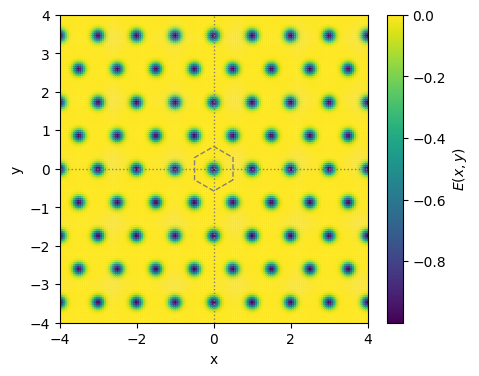

In [4]:
x0, x1, nx = -4, 4, 150
y0, y1, ny = -4, 4, 150
xx, yy = np.meshgrid(np.linspace(x0, x1, nx), np.linspace(y0, y1, ny))
pp = np.stack([xx, yy], axis=2)
p = np.reshape(pp, (pp.shape[0]*pp.shape[1], 2))

en, F, tau = pen_func(p, [0,0], *en_inputs)

fig, axE = plt.subplots(1,1, dpi=100, sharex=True, sharey=True, figsize=(5,4))
# fig.suptitle(title)
plt_params = {'ls': '--', 'color': 'tab:gray', 'lw': 1, 'fill': False}
s0 = 1

# Energy
sc = axE.scatter(p[:,0], p[:,1], c=en, s=s0)
plt.colorbar(sc, label=r'$E(x,y)$', ax=axE)
if params['well_shape'] != 'Sin': plot_BZ2d(axE, get_brillouin_zone_2d(S),plt_params)
#axE.legend(loc='upper right')
axE.set_xlim([x0, x1])
axE.set_ylim([y0, y1])
axE.set_ylabel('y')
axE.set_aspect('equal')
plt_cosmetic(axE)
plt.show()

###### Shortcut to plot the energy map
Plot the energy, forces and torque at each size.
!! If the size set is dense, this would restuls many images !!

In [5]:
def plot_map():
    #fig, ((axE, axFx), (axFy, axtau)) = plt.subplots(2,2, dpi=300, sharex=True, sharey=True, figsize=(8,6))
    fig, (axE, axFx, axFy, axtau) = plt.subplots(1,4, dpi=200, sharex=False, sharey=True, figsize=(10,2))
    plt_params = {'ls': '--', 'color': 'tab:gray', 'lw': 1, 'fill': False}
    s0 = 0.8 # Size of points
    marker = 's'
    # Plot limits
    x0, x1 = -1.2, 1.2
    y0, y1 = -1.2, 1.2

    # Energy
    # norm = Normalize(-N,0)
    norm = None
    sc = axE.scatter(pp[:,0], pp[:,1], c=enmap, s=s0, marker=marker, norm=norm)
    plt.colorbar(sc, label=r'$E(x,y)$', ax=axE)
    if params['well_shape'] != 'Sin': plot_BZ2d(axE, get_brillouin_zone_2d(S), plt_params)
    axE.quiver(0, 0, *S[0], angles='xy', scale_units='xy', scale=1, zorder=5, color='red', label=r' b1')
    axE.quiver(0, 0, *S[1], angles='xy', scale_units='xy', scale=1, zorder=5, color='orange', label=r' b2')
    #axE.legend()
    axE.set_xlim([x0, x1])
    axE.set_ylim([y0, y1])
    plt_cosmetic(axE)
    axE.set_ylabel(r'$y_\mathrm{cm}$')
    axE.set_xlabel('')
    #-------------------------

    # Force along x
    cside = np.max(np.abs(Fmap[:,0]))
    norm = Normalize(-cside, cside)
    sc = axFx.scatter(pp[:,0], pp[:,1], c=Fmap[:,0], s=s0, marker=marker, cmap='PiYG', norm=norm)
    plt.colorbar(sc, label=r'$F_x(x,y)$', ax=axFx)
    if params['well_shape'] != 'Sin': plot_BZ2d(axFx, get_brillouin_zone_2d(S), plt_params)
    axFx.set_xlim([x0, x1])
    axFx.set_ylim([y0, y1])
    plt_cosmetic(axFx)
    axFx.set_xlabel('')
    axFx.set_ylabel('')
    #-------------------------

    # Force along y
    cside = np.max(np.abs(Fmap[:,1]))
    norm = Normalize(-cside, cside)
    sc = axFy.scatter(pp[:,0], pp[:,1], c=Fmap[:,1], s=s0, marker=marker, cmap='PiYG', norm=norm)
    plt.colorbar(sc, label=r'$F_y(x,y)$', ax=axFy)
    if params['well_shape'] != 'Sin': plot_BZ2d(axFy, get_brillouin_zone_2d(S), plt_params)
    axFy.set_xlim([x0, x1])
    axFy.set_ylim([y0, y1])
    plt_cosmetic(axFy)
    axFy.set_xlabel(r'$x_\mathrm{cm}$')
    axFy.set_ylabel(r'$y_\mathrm{cm}$')
    #-------------------------

    # Torque
    cside = np.max(np.abs(taumap))
    norm = Normalize(-cside, cside)
    sc = axtau.scatter(pp[:,0], pp[:,1], c=taumap, s=s0, marker=marker, cmap='RdBu', norm=norm)
    plt.colorbar(sc, label=r'$\tau(x,y)$', ax=axtau)
    if params['well_shape'] != 'Sin': plot_BZ2d(axtau, get_brillouin_zone_2d(S), plt_params)
    axtau.set_xlim([x0, x1])
    axtau.set_ylim([y0, y1])
    plt_cosmetic(axtau)
    axtau.set_xlabel(r'$x_\mathrm{cm}$')
    axtau.set_ylabel('')
    #-------------------------

    plt.tight_layout()
    #plt.show()
    #print('-'*80, '\n')
    return fig, (axE, axFx, axFy, axtau)

### Commensurate

Start by computing the static friction in the commensurate (aligned) case.

In [6]:
# Selected sizes
Nls = np.array([5, 10, 15, 20, 25, 30])
# Linear range
Nls = np.arange(10, 100, 10)
# Log-spaced range
Nls = np.round(10**np.linspace(1, 2, 30)) # sizes make sense only as integers
Nls = np.unique(Nls) # in case we have duplicates

In [7]:
# Setup arrays 
Ns = np.zeros(Nls.shape[0])
Fsx = np.zeros(Nls.shape[0])
Fsc = np.zeros(Nls.shape[0])

t0 = time()
for iNl, cNl in enumerate(Nls):
    params['N1'] = cNl
    params['N2'] = cNl   
    
    # Create the cluster
    pos = cluster_from_params(params)
    N = pos.shape[0] # store the number of particles
    
    if iNl % int(Nls.shape[0]/10) == 0:
        print('%3i%%)On %10s cluster of size N=%4i (lattice side Nl=%4i)' % (100*iNl/Nls.shape[0], params['cluster_shape'], N, cNl))
    
    # It's more convenient to return a cluster in the origin, then shift and rotate outside of the function
    pos = rotate(pos, params['theta']) + params['pos_cm']

    # Compute
    data = static_traslmap(pos, {"da11": 0, "da12": 1, 
                                 "da21": 0, "da22": 1.,
                                 "nbin": 50,
                                 'S': S, 'en_params': en_inputs}, 
                           en_func, log_propagate=True)

    # Separate the output data into components 
    pp = data[:,:2]
    enmap = data[:,2]
    Fmap = data[:,3:5]
    Fmapn = np.linalg.norm(Fmap, axis=1) # norm of forces
    taumap = data[:,5]
    
    # Store the results for the current size
    Ns[iNl] = N
    Fsx[iNl] = np.max(Fmap[:,0]) # static friction along x
    Fsc[iNl] = np.max(Fmapn) # static friction as max force

    plot_flg = False
    if plot_flg:
        # Show 2D map
        fig, (axE, axFx, axFy, axtau) = plot_map()
        for ax in [axE, axFx, axFy]:
            ax.scatter(*pp[np.argmax(Fmapn)], marker='x', color='red')
        plt.show()
        # Show along x only
        #plt.plot(pp[:,0], Fmap[:,0], label='N=%i' % N)
        #plt.plot(pp[np.argmax(Fmap[:,0]),0], Fsx[iNl], 'o')
        #plt.xlabel(r'$x$')
        #plt.ylabel(r'$F_x$')
        #plt.legend()
#plt.show()
print('Done in %is' % (time()-t0))

  0%)On     circle cluster of size N=  87 (lattice side Nl=  10)
 10%)On     circle cluster of size N= 151 (lattice side Nl=  13)
 20%)On     circle cluster of size N= 237 (lattice side Nl=  16)
 30%)On     circle cluster of size N= 363 (lattice side Nl=  20)
 40%)On     circle cluster of size N= 605 (lattice side Nl=  26)
 50%)On     circle cluster of size N= 979 (lattice side Nl=  33)
 60%)On     circle cluster of size N=1603 (lattice side Nl=  42)
 70%)On     circle cluster of size N=2539 (lattice side Nl=  53)
 80%)On     circle cluster of size N=4069 (lattice side Nl=  67)
 90%)On     circle cluster of size N=6529 (lattice side Nl=  85)
Done in 36s


### Misaligned

Now rotate the cluster and compute the incommensurate (misaligned) case

In [14]:
params['theta'] = 1.5 #degrees
print('Orientation theta=%.5g' % params['theta'])

Orientation theta=1.5


In [15]:
# Setup arrays 
Ns = np.zeros(Nls.shape[0])
Fsx = np.zeros(Nls.shape[0])
Fsm = np.zeros(Nls.shape[0])

t0 = time()
for iNl, cNl in enumerate(Nls):
    params['N1'] = cNl
    params['N2'] = cNl   
    
    # Create the cluster
    pos = cluster_from_params(params)
    N = pos.shape[0] # store the number of particles
    
    if iNl % int(Nls.shape[0]/10) == 0:
        print('%3i%%)On %10s cluster of size N=%4i (lattice side Nl=%4i)' % (100*iNl/Nls.shape[0], params['cluster_shape'], N, cNl))
    
    # It's more convenient to return a cluster in the origin, then shift and rotate outside of the function
    pos = rotate(pos, params['theta']) + params['pos_cm']

    # Compute the energy, forces and torque maps within the unit cell for the current size
    data = static_traslmap(pos, {"da11": 0, "da12": 1, 
                                 "da21": 0, "da22": 1.,
                                 "nbin": 50,
                                 'S': S, 'en_params': en_inputs}, 
                           en_func, log_propagate=True)

    # Separate the output data into components 
    pp = data[:,:2]
    enmap = data[:,2]
    Fmap = data[:,3:5]
    Fmapn = np.linalg.norm(Fmap, axis=1) # norm of forces
    taumap = data[:,5]

    # Store the results for the current size
    Ns[iNl] = N
    Fsx[iNl] = np.max(Fmap[:,0]) # static friction along x
    Fsm[iNl] = np.max(Fmapn) # static friction as max force

    plot_flg = False
    if plot_flg:
        # Show 2D map
        fig, (axE, axFx, axFy, axtau) = plot_map()
        for ax in [axE, axFx, axFy]:
            ax.scatter(*pp[np.argmax(Fmapn)], marker='x', color='red')
        plt.show()
        # Show along x only
        #plt.plot(pp[:,0], Fmap[:,0], label='N=%i' % N)
        #plt.plot(pp[np.argmax(Fmap[:,0]),0], Fsx[iNl], 'o')
        #plt.xlabel(r'$x$')
        #plt.ylabel(r'$F_x$')
        #plt.legend()
#plt.show()
print('Done in %is' % (time()-t0))

  0%)On     circle cluster of size N=  87 (lattice side Nl=  10)
 10%)On     circle cluster of size N= 151 (lattice side Nl=  13)
 20%)On     circle cluster of size N= 237 (lattice side Nl=  16)
 30%)On     circle cluster of size N= 363 (lattice side Nl=  20)
 40%)On     circle cluster of size N= 605 (lattice side Nl=  26)
 50%)On     circle cluster of size N= 979 (lattice side Nl=  33)
 60%)On     circle cluster of size N=1603 (lattice side Nl=  42)
 70%)On     circle cluster of size N=2539 (lattice side Nl=  53)
 80%)On     circle cluster of size N=4069 (lattice side Nl=  67)
 90%)On     circle cluster of size N=6529 (lattice side Nl=  85)
Done in 42s


### Plot the different scalings

Now that we have generated the data, we can plot the computed friction and compare it to the expected scaling.

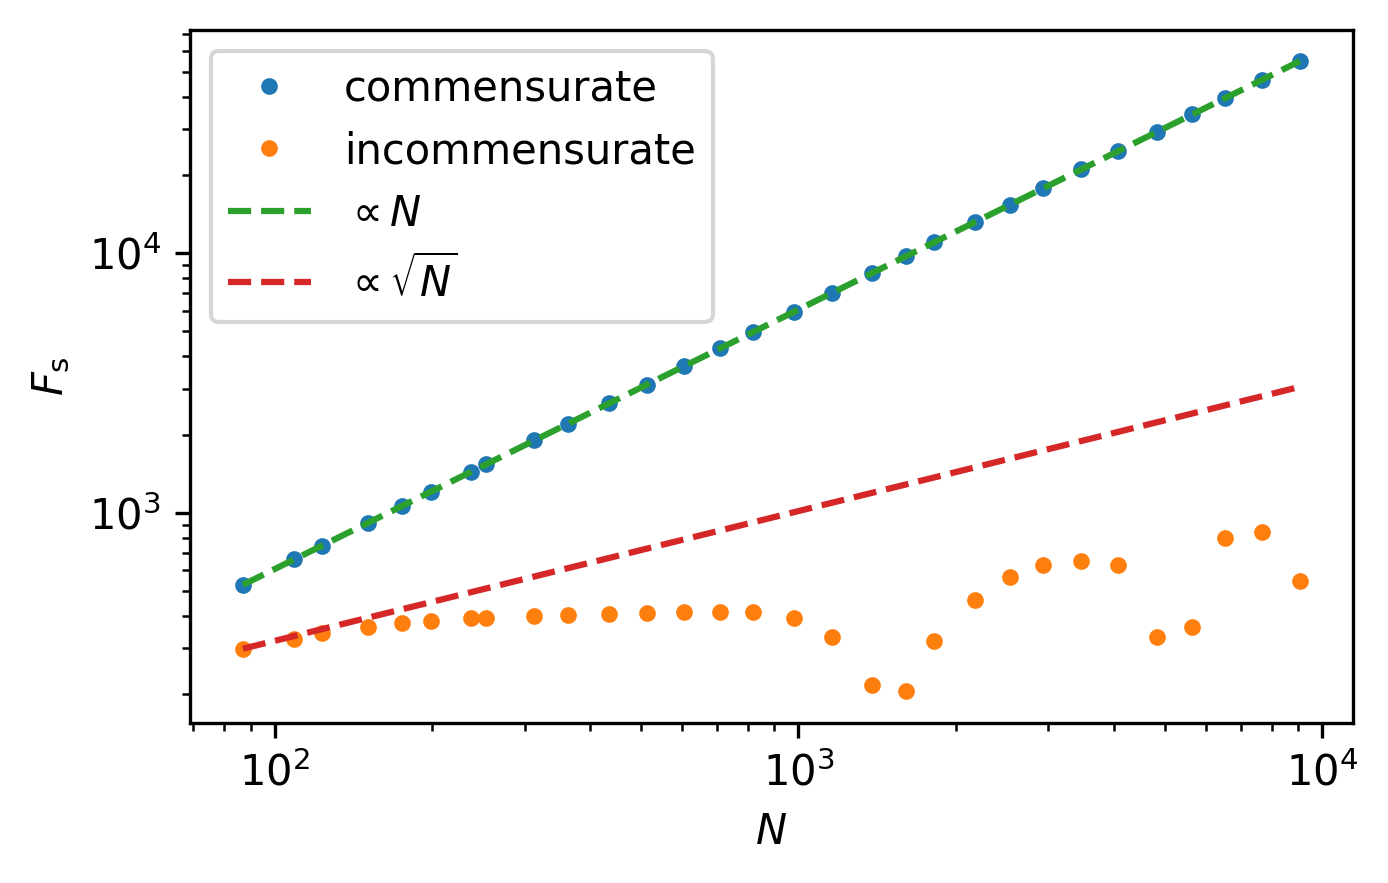

In [16]:
# Plot data
plt.plot(Ns, Fsc, '.', label='commensurate')
plt.plot(Ns, Fsm, '.', label='incommensurate')
# Scaling laws
plt.plot(Ns, (Fsc[0]/Ns[0])*Ns, '--', label=r'$\propto N$')
plt.plot(Ns, (Fsm[0]/Ns[0]**(0.5))*Ns**0.5, '--', label=r'$\propto \sqrt{N}$')
# Cosmetics
plt.loglog()
plt.legend()
plt.xlabel(r'$N$')
plt.ylabel(r'$F_{\mathrm{s}}$')
plt.gcf().set_size_inches((5,3))
plt.gcf().set_dpi(300)
plt.show()

As expected, in the commensurate case the friction $F_\mathrm{s}$ scales _linearly_ with the size: each particle sits at the bottom of a potential well and each experience the same maximum force when the cluster is translated.

In the incommensurate (misaligned) case, the friction $F_\mathrm{s}$ scales _sublinearly_ with the size [1]: each particles sit in a sligthly different point of substrate potential and experience a difference force. As the cluster is translated, these forces cancel each other and the net force felt by the cluster grows slower than for a commensurate interface. The non-monotonic behaviour is linked to the number of complete [moiré tiles](https://en.wikipedia.org/wiki/Moiré_pattern) fitting in the cluster, which control the compensation effect [2,3]. This is the [structural superlubrcity](https://en.wikipedia.org/wiki/Superlubricity) effect [1,4,5,6].

[1] Dietzel, Dirk, Michael Feldmann, Udo D. Schwarz, Harald Fuchs, and André Schirmeisen. “Scaling Laws of Structural Lubricity.” Physical Review Letters 111, no. 23 (December 2, 2013): 235502. https://doi.org/10.1103/PhysRevLett.111.235502.

[2] Koren, E., and U. Duerig. “Moiré Scaling of the Sliding Force in Twisted Bilayer Graphene.” Physical Review B 94, no. 4 (July 5, 2016): 045401. https://doi.org/10.1103/PhysRevB.94.045401.

[3] Panizon, Emanuele, Andrea Silva, Xin Cao, Jin Wang, Clemens Bechinger, Andrea Vanossi, Erio Tosatti, and Nicola Manini. “Frictionless Nanohighways on Crystalline Surfaces.” Nanoscale 15, no. 3 (2023): 1299–1316. https://doi.org/10.1039/D2NR04532J.

[4] Dienwiebel, Martin, Gertjan S. Verhoeven, Namboodiri Pradeep, Joost W. M. Frenken, Jennifer A. Heimberg, and Henny W. Zandbergen. “Superlubricity of Graphite.” Physical Review Letters 92, no. 12 (March 24, 2004): 126101. https://doi.org/10.1103/PhysRevLett.92.126101.

[5] Cihan, Ebru, Semran İpek, Engin Durgun, and Mehmet Z. Baykara. “Structural Lubricity under Ambient Conditions.” Nature Communications 7, no. 1 (June 28, 2016): 12055. https://doi.org/10.1038/ncomms12055.

[6] Vanossi, Andrea, Clemens Bechinger, and Michael Urbakh. “Structural Lubricity in Soft and Hard Matter Systems.” Nature Communications 11, no. 1 (September 16, 2020): 4657. https://doi.org/10.1038/s41467-020-18429-1.
